# Intro to JuMP

This notebook is based on materials by Kayla Cummings https://github.com/kscummings/15.S60_2022/tree/main/6_linear_programming

Now that we are familiar with Julia syntax and packages, let's take a look at how to build linear programs in Julia using the JuMP package! 

### Notebook outline

1. Build and solve a simple model! (Easy peasy)
2. Incorporate some fancier data pre-processing
3. Build and solve a large number of similar LPs (modularize!)

_Note_: The preassignment did not include packages Distances, Random, and StatsBase; please install those by uncommenting the line below.

[JuMP.jl](https://github.com/JuliaOpt/JuMP.jl) is a high-level modeling language for mathematical optimization developed in Julia. It currently supports 
- a bajillion solvers (Artelys Knitro, BARON, Bonmin, Cbc, Clp, Couenne, CPLEX, ECOS, FICO Xpress, GLPK, Gurobi, Ipopt, MOSEK, NLopt, SCS) 
- many problem classes, including linear programming, (mixed) integer programming, second-order conic programming, semidefinite programming, and nonlinear programming.

In [ ]:
# using Pkg; Pkg.add("Distances"); Pkg.add("StatsBase"); Pkg.add("Random")

In [1]:
using JuMP, Gurobi, CSV, DataFrames, Plots, Distances, StatsBase, Random

const GRB_ENV = Gurobi.Env();

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-12


## 1. Building and solving simple models

Let's check out the basic syntax of building a linear program in Julia with JuMP.

How would be formulate the following?

\begin{align}
\min \quad &e'x \\
\text{s.t. } \quad &A x\geq b \\
&x \geq 0
\end{align}

In [60]:
#--- generate random parameters 
n = 10
A = round.(rand(n, n), digits=2)   # random resource matrix
b = round.(rand(n) * 5, digits=2); # randm demand

In [4]:
#--- construct the model
m = JuMP.Model(() -> Gurobi.Optimizer(GRB_ENV))
JuMP.@variable(m, x[1:n] >= 0)
JuMP.@constraint(m, resource, A*x .>= b)
JuMP.@objective(m, Min, sum(x));

LoadError: UndefVarError: JuMP not defined

In [63]:
#--- look at it!
JuMP.latex_formulation(m)

$$ \begin{aligned}
\min\quad & x_{1} + x_{2} + x_{3} + x_{4} + x_{5} + x_{6} + x_{7} + x_{8} + x_{9} + x_{10}\\
\text{Subject to} \quad & 0.31 x_{1} + 0.99 x_{2} + 0.55 x_{3} + 0.65 x_{4} + 0.53 x_{5} + 0.04 x_{6} + 0.32 x_{7} + 0.9 x_{8} + 0.57 x_{9} + 0.37 x_{10} \geq 0.53\\
 & 0.24 x_{1} + 0.9 x_{2} + 0.05 x_{3} + 0.44 x_{4} + 0.35 x_{5} + 0.26 x_{6} + 0.79 x_{7} + 0.03 x_{8} + 0.36 x_{9} + 0.77 x_{10} \geq 0.6\\
 & 0.55 x_{1} + 0.89 x_{2} + 0.95 x_{3} + 0.65 x_{4} + 0.78 x_{5} + 0.75 x_{6} + 0.64 x_{7} + 0.21 x_{8} + 0.39 x_{9} + 0.53 x_{10} \geq 2.99\\
 & 0.09 x_{1} + 0.62 x_{2} + 0.04 x_{3} + 0.96 x_{4} + 0.03 x_{5} + 0.89 x_{6} + 0.28 x_{7} + 0.25 x_{8} + 0.35 x_{9} + 0.53 x_{10} \geq 3.4\\
 & 0.51 x_{1} + 0.46 x_{2} + 0.74 x_{3} + 0.7 x_{4} + 0.9 x_{5} + 0.75 x_{6} + 0.68 x_{7} + 0.88 x_{8} + 0.79 x_{9} + 0.89 x_{10} \geq 3.85\\
 & 0.7 x_{1} + 0.87 x_{2} + 0.66 x_{3} + 0.32 x_{4} + 0.86 x_{5} + 0.17 x_{6} + 0.88 x_{7} + 0.25 x_{8} + 0.27 x_{9} + 0.32 x_{10} \geq 2.63\\
 & 0.05 

In [64]:
#--- solve!
JuMP.optimize!(m)

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10 rows, 10 columns and 100 nonzeros
Model fingerprint: 0x976ab350
Coefficient statistics:
  Matrix range     [1e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 5e+00]
Presolve time: 0.00s
Presolved: 10 rows, 10 columns, 100 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.409000e+01   0.000000e+00      0s
       3    7.4779074e+00   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.00 seconds (0.00 work units)
Optimal objective  7.477907418e+00

User-callback calls 40, time in user-callback 0.00 sec


In [67]:
#--- optimal value?
obj = JuMP.objective_value(m)

7.477907417873816

### That's quite the print-out! What do we do with it? 
The solver log has some useful information! ([Here](https://www.gurobi.com/documentation/9.5/refman/logging.html) is a comprehensive summary of Gurobi logging.)

* Summary of model size
* Parameter ranges (troubleshoot numerical errors)
* Dual simplex solution progress
    * Objective value of current basis
    * Magnitudes of primal and dual infeasibility
    * Iteration and time elapsed
* Objective value
* Tottal solve time
* Callback summaries

However, if you want to turn it off...

In [51]:
solver = JuMP.optimizer_with_attributes(() -> Gurobi.Optimizer(GRB_ENV), "OutputFlag" => 0)
m = JuMP.Model(solver)

# while we're at it... an equivalent way to formulate, without matrix ops
JuMP.@variable(m, x[1:n] >= 0)
JuMP.@constraint(m, resource[i=1:n], sum(A[i,j] * x[j] for j in 1:n) >= b[i])
JuMP.@objective(m, Min, sum(x[j] for j in 1:n));

In [49]:
#--- so quiet...
JuMP.optimize!(m)

In [66]:
#--- equivalent?
JuMP.objective_value(m) == obj

true

### Gurobi attributes

Gurobi offers a lot of solver parameters. There are [a lot](https://www.gurobi.com/documentation/9.5/refman/parameters.html).
Here are just a few:

* ``TimeLimit``: Max time solver will run (in seconds)
* ``NodeLimit``: Max nodes to explore before solver quits
* ``MIPGap``: Termination criterion for relative gap $\frac{UB-LB}{LB}$.
* ``MIPFocus``: High-level controls on solver priority (proving optimality or increasing bound or finding optimal solution).

Set their values in the solver definition.
```
solver = JuMP.optimizer_with_attributes(() -> Gurobi.Optimizer(GRB_ENV), "OutputFlag" => 0, "TimeLimit" => 60)
```


### Common model queries

What other information do we want to squeeze out of our model?
* Primal and dual solutions
* Termination status (possible outcomes [here](https://jump.dev/JuMP.jl/stable/moi/reference/models/#MathOptInterface.TerminationStatusCode))

In [70]:
@show JuMP.value.(x);                # primal solution

JuMP.value.(x) = [0.0, 0.6840687204341865, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.78336339916848, 4.01047529827115]


In [71]:
@show JuMP.shadow_price.(resource);  # dual solution

JuMP.shadow_price.(resource) = [-0.0, -0.0, -0.0, -0.0, -0.0, -0.48524709471125194, -0.0, -0.5845417734455446, -0.9281052330037703, -0.0]


In [72]:
@show JuMP.termination_status(m);     # did the model get solved to optimality?

JuMP.termination_status(m) = MathOptInterface.OPTIMAL


### Exercise

Implement and solve the dual of our tiny optimization model up there. Verify that you get the same objective value!

In [ ]:
#--- code here
d = JuMP.Model(() -> Gurobi.Optimizer(GRB_ENV))
####
#### YOUR CODE HERE
####

In [81]:
# Check if you're correct
abs(JuMP.objective_value(d) - obj) < 1e-5

true

## Where to get help

Source https://github.com/adelarue/cos_2021/blob/main/6%2B7_julia_and_jump/intro-jump-and-applications.ipynb 
- JuMP docs https://www.juliaopt.org/JuMP.jl/v0.20.0/
- JuMP issues https://github.com/JuliaOpt/JuMP.jl/issues
- JuMP tutorial notebooks package https://github.com/JuliaOpt/JuMPTutorials.jl
- Discourse https://discourse.julialang.org/c/domain/opt
- Julia slack channels https://app.slack.com/client/T68168MUP/C66NPKCQZ/thread/C681S52FQ-1577546443.051000 
- JuMP style guide https://www.juliaopt.org/JuMP.jl/dev/style/
- Examples in the JuMP Github repo https://github.com/JuliaOpt/JuMP.jl/tree/master/examples

## 2. Building a model with fancy data pre-processing

That was great and all, but what about the unsexy side of things where I have a bunch of datasets that I need to translate into model inputs? How do I do that and stay organized?? Let's set up a case study.

Greater Boston Area needs to make sure that its citizens are vaccinated from Omicron. Their goal is to vaccinate everyone. Let's respect a statewide budget and minimize total distance traveled by those being vaccinated. Where should GBA set up temporary mass vaccination sites?

**Sets**
* Cities and towns $C$
* Potential vaccination facilities $F$

**Parameters**
* $r_{j}$ - number of persons in city $j \in C$ who need to be vaccinated 
* $d_{ij}$ - distance from facility $i \in F$ to city $j \in C$ (assume the same for everyone in area $j$)
* $K_i$ - fixed cost of opening facility $i \in F$ 
* $P_i$ - number of persons who can be vaccinated at facility $i \in F$, assuming the facility is open
* $B$ - budget for opening facilities
* $L$ - maximum number of vaccination sites open

**Decisions**
* $x_{ij}$ - number of people in city $j \in C$ vaccinated at site $i \in F$ 
* $y_i$ - whether facility $i \in F$ is open

**Formulation**

\begin{align}
\min \quad &\sum_{i \in F} \sum_{j \in C} d_{ij} \cdot x_{ij} \\
\text{s.t. } \quad &\sum_{i \in F} K_i \cdot y_i \leq B && &&\text{Budget} \\
&\sum_{i \in F} y_i \leq L && &&\text{Location limit}\\
&\sum_{j \in C}x_{ij} \leq P_i \cdot y_{i} &&i \in F &&\text{Capacity} \\
&\sum_{i \in F}x_{ij} = r_{j} &&j \in C &&\text{Demand} \\
&x_{ij} \geq 0 &&i \in F, j \in C \\
&y_{i} \in \{0,1\} &&i \in F \\
\end{align}

### 2.0 From raw data to formatted data

* MA population at ZIP code level ([source](https://censusreporter.org/data/table/?table=B01003))
* Prettier ZIP code names ([source](https://www.zip-codes.com/state/ma.asp))
* Potential facility locations and their capacities/costs (source: simulated!)

I formatted the data in Python to obtain the centroids of each ZIP code. If you want to see how that was done, the script is in the raw data directory.

### 2.1 From formatted data to model inputs

Let's read in our formatted data toward constructing the sets and parameters that we need.

In [67]:
#--- data paths and constants
data_dir = joinpath("data", "formatted")
pop_fn = joinpath(data_dir, "ma_population.csv")
fac_fn = joinpath(data_dir, "facilities.csv")

hav = Distances.Haversine(3958.8); # radius of Earth in miles

In [68]:
#--- population data
pop_dat = DataFrame(CSV.File(pop_fn))

,geoid,population,pop_error,longitude,latitude,city,county
,String15,Float64,Float64,Float64,Float64,String31,String15
1,86000US01730,14070.0,52.0,-71.2783,42.4969,Bedford,Middlesex
2,86000US01731,2059.0,142.0,-71.2795,42.4568,Hanscom AFB,Middlesex
3,86000US01801,40359.0,91.0,-71.1542,42.4869,Woburn,Middlesex
4,86000US01803,27650.0,67.0,-71.2026,42.5022,Burlington,Middlesex
5,86000US01810,35816.0,55.0,-71.1651,42.6465,Andover,Essex
6,86000US01821,32797.0,525.0,-71.2522,42.5502,Billerica,Middlesex
7,86000US01833,8695.0,20.0,-70.9821,42.724,Georgetown,Essex
8,86000US01840,5573.0,567.0,-71.1602,42.7069,Lawrence,Essex
9,86000US01841,49367.0,1134.0,-71.1651,42.7108,Lawrence,Essex


In [69]:
#--- facility data (simulated)
fac_dat = CSV.read(fac_fn, DataFrame)

,latitude,longitude,capacity,fixed_cost,facility_id
,Float64,Float64,Float64,Float64,String7
1,42.467,-71.1851,403680.0,4.0458e5,fac3
2,42.5802,-70.7361,53920.0,54819.7,fac36
3,42.4578,-71.0891,227470.0,2.2837e5,fac20
4,42.5532,-71.1816,233860.0,2.3476e5,fac19
5,42.587,-71.2954,106320.0,1.0722e5,fac14
6,42.4348,-70.8908,35110.0,36009.7,fac27
7,42.683,-70.8731,63810.0,64709.7,fac41
8,42.2029,-70.8373,84930.0,85829.7,fac47
9,42.5806,-70.9341,274150.0,2.7505e5,fac30


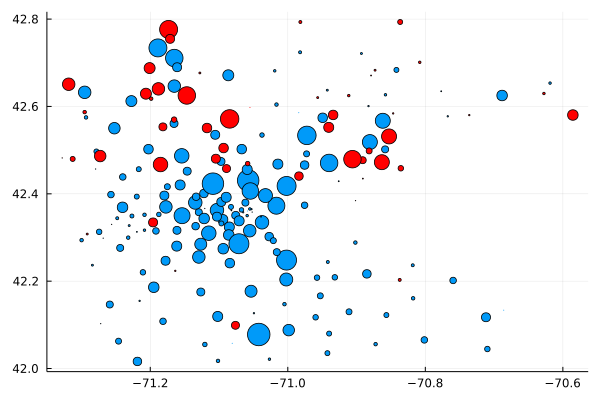

In [70]:
#--- visualize
scatter(pop_dat[:, "longitude"], pop_dat[:, "latitude"], markersize=0.0002*pop_dat[:, "population"], legend=false)
scatter!(fac_dat[:, "longitude"], fac_dat[:, "latitude"], color="red", markersize=0.00002*fac_dat[:, "capacity"])

Imagine a map of the GBA underneath the dots... ;)

### What input formatting needs to be done?

Some model attributes are straightforward translations of dataframe columns:
* zip codes and facility IDs - $C, F$
* facility capacities - $P$
* fixed facility costs - $K$
* demand - $r$

Others are constants:
* budget - $B$
* max number of facilities - $L$

And some need to be computed:
* distances between facilities and residents - $d$

### Collecting all of the model components

This is a lot of stuff to keep track of. How can I keep everything organized?

We will create a Julia struct, which is a flexible data structure that can keep track of attributes of all types. If you are familiar with Python, a struct is analogous to a class, but we cannot assign methods to it.

In [9]:
struct FacilityLocationData
    #--- constants 
    L::Int64        # location limit
    B::Float64      # budget
    
    #--- sets
    C::Vector{String}  # zip codes 
    F::Vector{String}  # facility IDs
    
    #--- parameters
    r::Dict{String,Int64}                  # demand 
    P::Dict{String,Int64}                  # daily capacity
    K::Dict{String,Float64}                # fixed cost
    d::Dict{Tuple{String,String},Float64}  # distances
    
    #--- extra information
    city_county::Dict{String,String}             # city/county zip code map
    pop_gps::Dict{String,Tuple{Float64,Float64}} # GPS points of each zip code
    fac_gps::Dict{String,Tuple{Float64,Float64}} # GPS points of each facility
end

We cannot change the struct once it has been created. If we want to be able to change values, we create a mutable struct instead. (Just put the word "mutable" in front of struct at the top of the previous cell.)

Let's build a constructor for our FacilityLocationData data structure. We are taking advantage of the fact that Julia functions can have many _methods_.

### Exercise

Part of the constructor has been completed before you. But part of it hasn't... fill in the missing model components.

_Hint_: If you need to explore a dataset, create a new cell and use the dataframes loaded above.

In [38]:
"""
CONSTRUCTOR

### Keywords
* `pop_fp` - MA population filepath
* `fac_fp` - facility location filepath
* `L` - max facility locations that can be opened
* `B` - budget
"""
function FacilityLocationData(
        pop_fp::String,
        fac_fp::String,
        L::Int64=20,
        B::Float64=4e6
    )
    # read in raw data
    # note: this code is redundant with the above code, but that was preliminary data exploration!
    pop_dat = CSV.read(pop_fp, DataFrame)
    pop_dat[:, "zip_code"] = replace.(pop_dat[:, "zip_code"], "z" => "")
    fac_dat = CSV.read(fac_fp, DataFrame) 
    
    # some extra info available in the pop dataframe
    city_county = Dict{String,String}(
        row["zip_code"] => row["city"] .* ", " .* row["county"] for row in eachrow(pop_dat) 
            if (!ismissing(row["city"]) & !ismissing(row["county"]))
    )
    pop_gps = Dict{String,Tuple{Float64,Float64}}(
        pop_dat[:, "zip_code"] .=> tuple.(pop_dat[:, "latitude"], pop_dat[:, "longitude"])
    )
    fac_gps = Dict{String,Tuple{Float64,Float64}}(
        fac_dat[:, "facility_id"] .=> tuple.(fac_dat[:, "latitude"], fac_dat[:, "longitude"])
    )
                
    # distances
    d = Dict{Tuple{String,String},Float64}(
        (res, fac) => Distances.evaluate(hav, rgps, fgps) for (res, rgps) in pop_gps for (fac, fgps) in fac_gps
    )
    
    ########### YOUR CODE HERE
    ########### SETS
    C = String[] # zip codes
    F = String[] # facility IDs

    ########### YOUR CODE HERE
    ########### FACILITY AND POPULATION PARAMETERS
    P = Dict{String,Int64}() # capacity
    K = Dict{String,Float64}() # fixed cost
    r = Dict{String,Int64}() # demand
                            
    return FacilityLocationData(L, B, C, F, r, P, K, d, city_county, pop_gps, fac_gps)
end

FacilityLocationData

In [6]:
FLD = FacilityLocationData(pop_fn, fac_fn);

LoadError: UndefVarError: FacilityLocationData not defined

Now we can access any model attribute by name. Try it out!

In [14]:
@show FLD.F;

FLD.F = ["fac3", "fac36", "fac20", "fac19", "fac14", "fac27", "fac41", "fac47", "fac30", "fac4", "fac24", "fac1", "fac18", "fac28", "fac6", "fac2", "fac45", "fac44", "fac42", "fac33", "fac35", "fac37", "fac32", "fac5", "fac9", "fac17", "fac25", "fac15", "fac21", "fac8", "fac50", "fac16", "fac7", "fac29", "fac46", "fac43", "fac34", "fac23", "fac48", "fac49", "fac26", "fac13", "fac22", "fac39", "fac40", "fac12", "fac11", "fac38", "fac31", "fac10"]


What was the point of all of that? Can't we just use the parameter names themselves?

Well, good extensible code is _modularized_! By limiting all of our model components to one data structure, we have drastically simplified the arguments to any functions that build and solve models.

We want code that looks roughly like this:

```
FLD = FacilityLocationData(data_dir)
model = build_model(FLD)
solution = solve_model(model)
```

Look how lovely and legible that is! As we know, line 1 hides a lot of work. But now we have designed narrative, extensible code. If we need more info, we can go to the function(s) containing that info. Let's get to work on lines 2 and 3...

### 2.2 Model formulation

Now what? Let's work on a `build_model` function.



### Exercise

Formulate the above model in JuMP using the inputs we just formatted.

Before you begin, here is some syntax that may be useful.

```
@variables m begin
    variable1_name >= 0
    variable2_name, Bin
end

@constraints m begin
    opt_constraint1_name, constraint1
    opt_constraint2_name[constraint2_index], constraint2
end
```

The above is a less verbose, equivalent way of coding:
```
@variable(m, variable1_name >= 0)
@variable(m, variable2_name, Bin)
@constraint(m, opt_constraint1_name, constraint1)
@constraint(m, opt_constraint2_name[constraint2_index], constraint2)
```

As a reminder, here's the formulation.


\begin{align}
\min \quad &\sum_{i \in F} \sum_{j \in C} d_{ij} \cdot x_{ij} \\
\text{s.t. } \quad &\sum_{i \in F} K_i \cdot y_i \leq B && &&\text{Budget} \\
&\sum_{i \in F} y_i \leq L && &&\text{Location limit}\\
&\sum_{j \in C}x_{ij} \leq P_i \cdot y_{i} &&i \in F &&\text{Capacity} \\
&\sum_{i \in F}x_{ij} = r_{j} &&j \in C &&\text{Demand} \\
&x_{ij} \geq 0 &&i \in F, j \in C \\
&y_{i} \in \{0,1\} &&i \in F \\
\end{align}

In [19]:
"""
Build MA facility location model.

### Keywords 
* `FLD` - FacilityLocationData
### Returns
* JuMP.Model representation of MA's mass vaccination site problem
"""
function build_model(FLD::FacilityLocationData)
    m = JuMP.Model(Gurobi.Optimizer)
    
    ###### YOUR CODE HERE
    # BUILD THE MODEL - YOU GOT IT!
                    
    return m
end

build_model

In [32]:
#--- try it out!
m = build_model(FLD)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-12


A JuMP Model
Minimization problem with:
Variables: 8150
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 162 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 52 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 8100 constraints
`VariableRef`-in-`MathOptInterface.ZeroOne`: 50 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Gurobi
Names registered in the model: budget, capacity, demand, num_loc, x, y

### 2.3 Solve model

Let's build a function to solve our model. Then we can explore and interpret our optimal solution.

In [23]:
"""
Solve a mass COVID vaccination facility location model 

### Keywords 
* `model` - the model
### Returns 
* termination status
* objective value
* optimal solution (x, y)
"""
function solve_model(model::JuMP.Model)
    JuMP.optimize!(model)
    term_status = JuMP.termination_status(model)
    if term_status == MOI.OPTIMAL
        obj = JuMP.objective_value(model)
        x_val = JuMP.value.(model[:x])
        y_val = JuMP.value.(model[:y])
        return term_status, obj, (x_val, y_val)
    end
    return term_status, nothing, nothing
end
# this function is looking the other way while we talk about type stability...

solve_model

In [33]:
ts, obj, (x_val, y_val) = solve_model(m);

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 214 rows, 8150 columns and 16350 nonzeros
Model fingerprint: 0xd18f6b1f
Variable types: 8100 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+05]
  Objective range  [1e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 4e+06]
Found heuristic solution: objective 4.688290e+07
Presolve time: 0.02s
Presolved: 214 rows, 8150 columns, 16350 nonzeros
Variable types: 8100 continuous, 50 integer (50 binary)

Root relaxation: objective 1.027966e+07, 143 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1.0280e+07    0   23 4.6883e+07 1.0280e+07  78.1%     -    0s
H    0     0                    1.653594e+07 1.0280e+07  37.8%

### 2.4 Put it all together

Let's see our three-line script in action :-)

In [40]:
F = FacilityLocationData(pop_fn, fac_fn)
m = build_model(F)
ts, obj, sol = solve_model(m);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-12
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 214 rows, 8150 columns and 16350 nonzeros
Model fingerprint: 0xd18f6b1f
Variable types: 8100 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+05]
  Objective range  [1e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 4e+06]
Found heuristic solution: objective 4.688290e+07
Presolve time: 0.02s
Presolved: 214 rows, 8150 columns, 16350 nonzeros
Variable types: 8100 continuous, 50 integer (50 binary)

Root relaxation: objective 1.027966e+07, 143 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1.0280e+07    0   23 4.6883e+07 1

## 3. Analyze outputs

There are a few scenarios where our 3-line script is going to save us a lot of trouble:
* Different (but very similar) datasets - e.g., repeat for all 50 states, not just MA
* Sensitivity analysis

### Exercise 
Let's do a little bit of the latter. We will plot the effect of budget on total distance traveled by all residents to get their vaccines. Fix the number of facilities at 20. In the cell below, compute the total distance traveled by all residents in the optimal facility location for each tested budget.

In [61]:
budget = [3 + i * .2 for i in 0:10] .* 10^6
NB = length(budget)
dist = Float64[NaN for _ in 1:NB]

##### YOUR CODE HERE
    


Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-12
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 214 rows, 8150 columns and 16350 nonzeros
Model fingerprint: 0xc5988df7
Variable types: 8100 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+05]
  Objective range  [1e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 3e+06]
Presolve time: 0.02s
Presolved: 214 rows, 8150 columns, 16350 nonzeros
Variable types: 8100 continuous, 50 integer (50 binary)

Root relaxation: infeasible, 211 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0               - infeasible      -     -    0s

Explored 1 nodes (211 simplex i

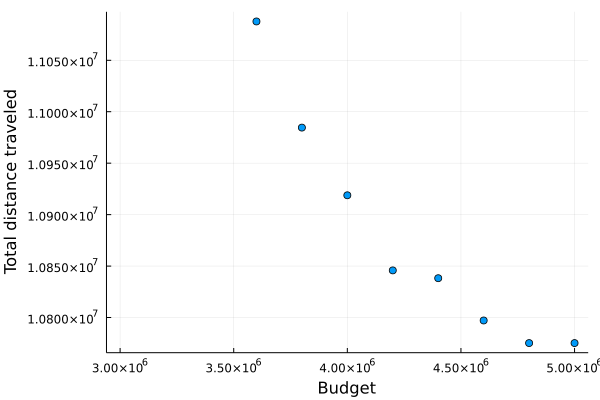

In [63]:
# check: is the distance decreasing as budget increases?
scatter(budget, dist, ylab="Total distance traveled", xlab="Budget", legend=false)

# Appendix

Here's how the facility data was simulated.

In [66]:
# using Pkg; Pkg.add("Distributions")
using Distributions, Random
Random.seed!(47)
pop_vec = pop_dat[:, "population"]
num_facilities = 50

# distributions
dist_lat = Normal.(pop_dat[:,"latitude"], 0.05)
dist_lon = Normal.(pop_dat[:, "longitude"], 0.05)
dist_cap = Normal(100, 10)
dist_fc = Normal(1e3, 100)

# locations (who knows if these are even in MA? on land??? oh well!)
fac_lat = rand.(dist_lat)
fac_lon = rand.(dist_lon)

# parameters
P = max.(round.(pop_vec .* 10 .+ rand(dist_cap)), 0)
K = pop_vec .* 10 .+ rand(dist_fc)

# facility IDs
facility_id = "fac" .* string.([i for i in 1:length(fac_lat)])

# format into a CSV
facilities = DataFrame(latitude = fac_lat, longitude = fac_lon, capacity = P, fixed_cost = K, facility_id = facility_id)
fac_idx = StatsBase.sample(1:nrow(fac_dat), num_facilities, replace=false)
facilities = facilities[fac_idx, :]  
CSV.write(joinpath("data", "formatted", "facilities.csv"), facilities);